#PUI Extra Credit

#####Dan Quasney

In [1]:
# Importing modules
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_regress_exog
import scipy.stats
%pylab inline
pl.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


### Google Drive link to data:
    https://drive.google.com/a/nyu.edu/folderview?id=0B0bpzcsN7MiJUmVZOWljMjJiaHM&usp=sharing

Please note:
### For best visual quality, download the notebook. Raw NBConvert do not show up properly on GitHub.

# Pollution data

In [2]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'Dist. of Col.',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
# Create list to store datasets
d = []
for k, v in states.iteritems():
    try: # If csv for one state should not be available, pass it
        load = 'Databases/Poll_daily/%s.csv' %(v.replace(' ','_').lower()) # read csv according to names
        temp = pd.read_csv(load)
        temp['state']=v # save the temporary dataset together with state info
        d.append(temp)
    except IOError:
        pass
    
df = pd.concat(d) # concatenate data pieces
print 'Observations per State'
print df.state.value_counts()
pivot = df.groupby('CBSA_NAME') # create a pivot-like table

Observations per State
California        36362
Texas             20367
Washington        19974
Florida           19818
Oregon            16641
Pennsylvania      16281
North Carolina    14236
New York          14121
Georgia           11306
Indiana           10868
Iowa              10480
Alabama            9324
Illinois           8546
Montana            8351
New Mexico         7570
Ohio               7474
New Jersey         7097
Massachusetts      6871
Utah               6606
Minnesota          6485
Louisiana          6261
Kentucky           6175
Oklahoma           5626
Missouri           5559
Michigan           4996
Idaho              4929
Arizona            4658
Maryland           4272
Wisconsin          4257
Maine              4096
South Carolina     3934
Virginia           3880
Hawaii             3801
Colorado           3791
Mississippi        3735
Alaska             3472
South Dakota       3438
Nevada             2974
Wyoming            2948
Tennessee          2883
Arkansas         

In [4]:
# Create pivot table with the mean of all daily pollution measurements, store it as DataFrame
test = pd.pivot_table(df, values=['Daily Mean PM2.5 Concentration'],
                      index=['CBSA_NAME','STATE'], aggfunc=[np.mean]).reset_index()
test = pd.DataFrame(test)

# Create pivot table with the count of individual stations in a CBSA, store it as DataFrame
test2 = pd.pivot_table(df, values=['AQS_SITE_ID'],index=['CBSA_NAME','STATE'], 
                       aggfunc=[lambda x: x.nunique()]).reset_index()
test2 = pd.DataFrame(test2)

# Get info on the shape of test files
# print test2

# Get rid of double header that won't allow a merger (second row is empty)
# Disassemble dataframe
test_mean = test['mean']
test_cbsa = test['CBSA_NAME']
test_state = test['STATE']
part1 = pd.concat([test_mean,test_cbsa,test_state],axis=1) # Reassemble dataframe

test2_cbsa = test2['CBSA_NAME']
test2_count = test2['<lambda>']
part2 = pd.concat([test2_count,test2_cbsa],axis=1)

# Merge data based on CBSA
pollution = pd.merge(part1,part2,on='CBSA_NAME',how='inner')
pollution['CBSAName_low'] = pollution['CBSA_NAME'].apply(lambda x: x.lower()) 
# Create a common column to merge coming datasets on

In [5]:
print pollution.head()
pollution.rename(columns={'Daily Mean PM2.5 Concentration':'pollution_mean','AQS_SITE_ID':'num_of_station','STATE':'state'},inplace=True)

   Daily Mean PM2.5 Concentration     CBSA_NAME         STATE  AQS_SITE_ID  \
0                        8.513793  Aberdeen, SD  South Dakota            1   
1                        3.464279  Aberdeen, WA    Washington            3   
2                        9.420904    Adrian, MI      Michigan            1   
3                       13.712731     Akron, OH          Ohio            3   
4                       12.321582    Albany, GA       Georgia            1   

   CBSAName_low  
0  aberdeen, sd  
1  aberdeen, wa  
2    adrian, mi  
3     akron, oh  
4    albany, ga  


In [6]:
pollution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 556
Data columns (total 5 columns):
pollution_mean    557 non-null float64
CBSA_NAME         557 non-null object
state             557 non-null object
num_of_station    557 non-null float64
CBSAName_low      557 non-null object
dtypes: float64(2), object(3)
memory usage: 26.1+ KB


# Population Density Data by CBSA

In [7]:
pop = pd.read_csv('Databases/Population/PopulationCBSA2010.csv')

In [8]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955 entries, 0 to 954
Data columns (total 5 columns):
CBSA_Code             955 non-null int64
CBSA                  955 non-null object
Population            955 non-null float64
Area                  955 non-null float64
Population Density    955 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 44.8+ KB


In [9]:
pop.rename(columns={'CBSA':'CBSAName','Population Density':'cbsa_density'}, inplace=True)

In [10]:
pop['CBSAName'] = pop['CBSAName'].astype(str)
pop.rename(columns={},inplace=True)
pop['cbsa_density'] = pop['cbsa_density'].convert_objects(convert_numeric=True)
for i in pop['CBSAName']:
    pop['CBSAName_low'] =  pop['CBSAName'].apply(lambda x: x.lower())

C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [11]:
print pop[pop['CBSAName_low']=='daphne-fairhope-foley, al']
print pollution[pollution['CBSAName_low']=='daphne-fairhope-foley, al']

     CBSA_Code                   CBSAName  Population     Area  cbsa_density  \
499      19300  Daphne-Fairhope-Foley, AL      182265  1589.78        114.65   

                  CBSAName_low  
499  daphne-fairhope-foley, al  
     pollution_mean                  CBSA_NAME    state  num_of_station  \
129       10.238525  Daphne-Fairhope-Foley, AL  Alabama               1   

                  CBSAName_low  
129  daphne-fairhope-foley, al  


In [12]:
final = pollution.merge(pop, on='CBSAName_low', how='inner')

In [13]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 0 to 522
Data columns (total 10 columns):
pollution_mean    523 non-null float64
CBSA_NAME         523 non-null object
state             523 non-null object
num_of_station    523 non-null float64
CBSAName_low      523 non-null object
CBSA_Code         523 non-null int64
CBSAName          523 non-null object
Population        523 non-null float64
Area              523 non-null float64
cbsa_density      523 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 44.9+ KB


In [14]:
final.drop('CBSA_NAME',axis=1,inplace=True)

#Census data on transportation modes

In [15]:
# Get columns metadata
column = pd.read_csv('Databases/Means of Transportation/ACS_10_1YR_S0801/ACS_10_1YR_S0801_metadata.csv')
# Get transportation data
trans = pd.read_csv('Databases/Means of Transportation/ACS_10_1YR_S0801/2010commute_match.csv',names=column['Id'])
list(trans.columns.values)[:10]

['Id2',
 'Geography',
 'Total; Estimate; Workers 16 years and over',
 'Total; Margin of Error; Workers 16 years and over',
 'Male; Estimate; Workers 16 years and over',
 'Male; Margin of Error; Workers 16 years and over',
 'Female; Estimate; Workers 16 years and over',
 'Female; Margin of Error; Workers 16 years and over',
 'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van',
 'Total; Margin of Error; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van']

In [16]:
# Get the columns we care about:
cols = ['Id2','Geography','Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Public transportation (excluding taxicab)',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Walked',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Bicycle',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Taxicab, motorcycle, or other means']
trans = trans[cols]
trans.reset_index(inplace=True)

In [17]:
trans.head()

,index,Id2,Geography,"Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van",Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Public transportation (excluding taxicab),Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Walked,Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Bicycle,"Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Taxicab, motorcycle, or other means"
0,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC03,HC01_EST_VC10,HC01_EST_VC11,HC01_EST_VC12,HC01_EST_VC13
1,310M100US10140,10140,"Aberdeen, WA Micro Area",85.4,2.6,3.4,0.3,0.9
2,310M100US10180,10180,"Abilene, TX Metro Area",90.4,0.7,2.1,0.4,2.3
3,310M100US10300,10300,"Adrian, MI Micro Area",90.0,0.3,4.4,1.0,0.7
4,310M100US10420,10420,"Akron, OH Metro Area",93.4,1.5,1.6,0.1,0.6


In [18]:
# Delete unwanted row (containing variable abbreviation)
trans.drop(0,inplace=True)
trans.rename(columns={'Geography':'CBSAName_low'},inplace=True)
trans[:2]

,index,Id2,CBSAName_low,"Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van",Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Public transportation (excluding taxicab),Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Walked,Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Bicycle,"Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Taxicab, motorcycle, or other means"
1,310M100US10140,10140,"Aberdeen, WA Micro Area",85.4,2.6,3.4,0.3,0.9
2,310M100US10180,10180,"Abilene, TX Metro Area",90.4,0.7,2.1,0.4,2.3


In [19]:
# Get rid of Micro/Macro Area ending
trans['CBSAName_low'] = trans['CBSAName_low'].astype(str)
print trans['CBSAName_low'][:10]

#trans['CBSAName'] = trans['CBSAName'].apply(lambda x: x.rstrip(r'M[icet]ro Area'))

# Delete Micro/Macro Area at the end for merging
trans['CBSAName_low'] = trans['CBSAName_low'].apply(lambda x: x.split('Metro',1)[0].strip())
trans['CBSAName_low'] = trans['CBSAName_low'].apply(lambda x: x.split('Micro',1)[0].strip().lower())

1                    Aberdeen, WA Micro Area
2                     Abilene, TX Metro Area
3                      Adrian, MI Micro Area
4                       Akron, OH Metro Area
5                      Albany, GA Metro Area
6              Albany-Lebanon, OR Micro Area
7     Albany-Schenectady-Troy, NY Metro Area
8                 Albertville, AL Micro Area
9                 Albuquerque, NM Metro Area
10                 Alexandria, LA Metro Area
Name: CBSAName_low, dtype: object


In [20]:
testing_x = trans[trans['CBSAName_low']=='daphne-fairhope-foley, al'].CBSAName_low
print testing_x.values[0]
print 'trans type:',type(testing_x.values[0])
print 'trans length:',len(testing_x.values[0])
print '...'
testing_y =  final[final['CBSAName_low']=='daphne-fairhope-foley, al'].CBSAName_low
print testing_y.values[0]
print 'final type:',type(testing_y.values[0])
print 'final length:',len(testing_y.values[0])
print '---'
print 'Now the two columns match'

daphne-fairhope-foley, al
trans type: <type 'str'>
trans length: 25
...
daphne-fairhope-foley, al
final type: <type 'str'>
final length: 25
---
Now the two columns match


In [21]:
final = pd.merge(final,trans, on='CBSAName_low',how='inner')
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 0 to 444
Data columns (total 16 columns):
pollution_mean                                                                                  445 non-null float64
state                                                                                           445 non-null object
num_of_station                                                                                  445 non-null float64
CBSAName_low                                                                                    445 non-null object
CBSA_Code                                                                                       445 non-null int64
CBSAName                                                                                        445 non-null object
Population                                                                                      445 non-null float64
Area                                                                             

In [22]:
# Get numeric value for percent estimates:
cols = ['Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Public transportation (excluding taxicab)',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Walked',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Bicycle',
        'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Taxicab, motorcycle, or other means']
for c in cols:
    final[c] = final[c].convert_objects(convert_numeric=True)

# Rename columns    
final.rename(columns={'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Car, truck, or van':'car',
                      'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Public transportation (excluding taxicab)':'public_tran',
                      'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Walked':'walk',
                      'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Bicycle':'bike',
                      'Total; Estimate; MEANS OF TRANSPORTATION TO WORK - Taxicab, motorcycle, or other means':'other'},inplace=True)    

# Drop missing in order to plot scatter
final.dropna(inplace=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 444
Data columns (total 16 columns):
pollution_mean    424 non-null float64
state             424 non-null object
num_of_station    424 non-null float64
CBSAName_low      424 non-null object
CBSA_Code         424 non-null int64
CBSAName          424 non-null object
Population        424 non-null float64
Area              424 non-null float64
cbsa_density      424 non-null float64
index             424 non-null object
Id2               424 non-null object
car               424 non-null float64
public_tran       424 non-null float64
walk              424 non-null float64
bike              424 non-null float64
other             424 non-null float64
dtypes: float64(10), int64(1), object(5)
memory usage: 56.3+ KB


C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#Energy data

In [23]:
energy = pd.read_csv('Databases/Energy/Energy.csv',header=2)
energy.drop(energy.columns[8:],axis=1,inplace=True)
energy = energy.convert_objects(convert_numeric=True)
energy[:2]

C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


,State,Total Energy,Coal,Natural Gas,Petroleum,Total Fossil,Nuclear Electric Power,Renewable Energy
0,Alabama,1931.4,565.1,628.5,508.0,1701.6,426.5,317.7
1,Alaska,609.0,14.8,333.0,240.7,588.5,0.0,20.4


In [24]:
d = {}
d['columns'] = pd.Series(energy.columns)
d['newcolumns'] = d['columns'].apply(lambda x: x.replace(' ','_').lower())
energy.columns = d['newcolumns']
energy[:2]

,state,total_energy,coal,natural_gas,petroleum,total_fossil,nuclear_electric_power,renewable_energy
0,Alabama,1931.4,565.1,628.5,508.0,1701.6,426.5,317.7
1,Alaska,609.0,14.8,333.0,240.7,588.5,0.0,20.4


In [25]:
print final['state'][:3]
print energy['state'][:3]

0    Washington
1      Michigan
2          Ohio
Name: state, dtype: object
0    Alabama
1     Alaska
2    Arizona
Name: state, dtype: object


In [26]:
# Transform columns into percent of total energy per state:
percent = ['coal', 'natural_gas', 'petroleum', 'total_fossil', 'nuclear_electric_power', 'renewable_energy']
for i in percent:
    energy[i] = energy[i]/energy.total_energy

In [27]:
energy[:2]

,state,total_energy,coal,natural_gas,petroleum,total_fossil,nuclear_electric_power,renewable_energy
0,Alabama,1931.4,0.292586,0.325412,0.263022,0.881019,0.220824,0.164492
1,Alaska,609.0,0.024302,0.546798,0.395238,0.966338,0.000000,0.033498


In [28]:
energy[energy['state'].str.contains('Dis')]['state']

8    Dist. of Col.
Name: state, dtype: object

In [29]:
# Ready to merge
final = pd.merge(final, energy, on='state', how='inner')
final[:2]

,pollution_mean,state,num_of_station,CBSAName_low,CBSA_Code,CBSAName,Population,Area,cbsa_density,index,...,walk,bike,other,total_energy,coal,natural_gas,petroleum,total_fossil,nuclear_electric_power,renewable_energy
0,3.464279,Washington,3,"aberdeen, wa",10140,"Aberdeen, WA",72797,1902.03,38.27,310M100US10140,...,3.4,0.3,0.9,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559
1,4.928976,Washington,2,"bellingham, wa",13380,"Bellingham, WA",201140,2106.86,95.47,310M100US13380,...,4.2,1.3,1.8,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559


In [30]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 423
Data columns (total 23 columns):
pollution_mean            424 non-null float64
state                     424 non-null object
num_of_station            424 non-null float64
CBSAName_low              424 non-null object
CBSA_Code                 424 non-null int64
CBSAName                  424 non-null object
Population                424 non-null float64
Area                      424 non-null float64
cbsa_density              424 non-null float64
index                     424 non-null object
Id2                       424 non-null object
car                       424 non-null float64
public_tran               424 non-null float64
walk                      424 non-null float64
bike                      424 non-null float64
other                     424 non-null float64
total_energy              424 non-null float64
coal                      424 non-null float64
natural_gas               424 non-null float64
petroleum

# Industry data per city

In [31]:
industry = pd.read_csv('Databases/Industry_by_Sector/ECN_2012_US_00A1/ECN_2012_US_00A1_with_ann.csv')

# Restrict data only to total observation for each city:
industry[(industry['OPTAX.display-label'] == 'Total') 
         | (industry['OPTAX.display-label'] == 'All establishments') 
         | (industry['OPTAX.display-label']=='Wholesale Trade')]

print 'Unique labels:',len(industry['NAICS.display-label'].unique())
print 'List of labels:',industry['NAICS.display-label'].unique()

Unique labels: 16
List of labels: ['Meaning of 2012 NAICS code' 'Utilities' 'Manufacturing' 'Wholesale trade'
 'Retail trade' 'Transportation and warehousing(104)' 'Information'
 'Finance and insurance' 'Real estate and rental and leasing'
 'Professional, scientific, and technical services'
 'Administrative and support and waste management and remediation services'
 'Educational services' 'Health care and social assistance'
 'Arts, entertainment, and recreation' 'Accommodation and food services'
 'Other services (except public administration)']


In [32]:
# Get rid of Micro or Macro Area:
print industry['GEO.display-label'][:2]
industry['CBSAName_low'] = industry['GEO.display-label'].astype(str)
industry['CBSAName_low'] = industry['CBSAName_low'].apply(lambda x: x.split('Metro',1)[0].strip())
industry['CBSAName_low'] = industry['CBSAName_low'].apply(lambda x: x.split('Micro',1)[0].strip().lower())
print industry['CBSAName_low'][:2]

0       Geographic area name
1    Aberdeen, SD Micro Area
Name: GEO.display-label, dtype: object
0    geographic area name
1            aberdeen, sd
Name: CBSAName_low, dtype: object


In [33]:
# Output to compare code to:
print industry[industry['CBSAName_low']=='daphne-fairhope-foley, al'][['CBSAName_low','ESTAB']][:3]

                   CBSAName_low ESTAB
4489  daphne-fairhope-foley, al    10
4490  daphne-fairhope-foley, al   146
4491  daphne-fairhope-foley, al   219


In [34]:
# Create a dataframe containing the establishments per city as columns:
util = {}
util['CBSAName_low'] = []
util['util'] = []
manuf = {}
manuf['manufact'] = []
manuf['CBSAName_low'] = []
trans = {}
trans['CBSAName_low'] = []
trans['trans_ware'] = []
for i,z in zip(industry['NAICS.display-label'],range(len(industry['NAICS.display-label']))):
    if i == 'Utilities':
        util['util'].append(industry['ESTAB'][z])
        util['CBSAName_low'].append(industry['CBSAName_low'][z])
for i,z in zip(industry['NAICS.display-label'],range(len(industry['NAICS.display-label']))):   
    if i == 'Manufacturing':
        manuf['manufact'].append(industry['ESTAB'][z])
        manuf['CBSAName_low'].append(industry['CBSAName_low'][z])
for i,z in zip(industry['NAICS.display-label'],range(len(industry['NAICS.display-label']))):      
    if i == 'Transportation and warehousing(104)':
        trans['trans_ware'].append(industry['ESTAB'][z])
        trans['CBSAName_low'].append(industry['CBSAName_low'][z])
        
util = pd.DataFrame(util)
manuf = pd.DataFrame(manuf)
trans = pd.DataFrame(trans)        

In [35]:
ind = pd.merge(util,manuf,on='CBSAName_low',how='inner')
ind = ind.merge(trans, on='CBSAName_low',how='inner')
ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 4 columns):
CBSAName_low    905 non-null object
util            905 non-null object
manufact        905 non-null object
trans_ware      905 non-null object
dtypes: object(4)
memory usage: 35.4+ KB


In [36]:
# Merge them separately as to not lose city observations not containing one of the industries:
finale = final.merge(util, on='CBSAName_low', how='inner')
finale = finale.merge(trans, on='CBSAName_low', how='inner')
finale = finale.merge(manuf, on='CBSAName_low', how='inner')

# Include Income data 
Median household data from census 2010 for CBSAs.

In [37]:
income = pd.read_csv('Databases/Income/ACS_10_1YR_S1901/ACS_10_1YR_S1901_with_ann.csv', header=1)

In [38]:
income = income[['Geography','Households; Estimate; Total']]
income.rename(columns={'Geography':'CBSAName_low','Households; Estimate; Total':'median_income'},inplace=True)
print income['CBSAName_low'][:3]
income['CBSAName_low'] = income['CBSAName_low'].astype(str)
income['CBSAName_low'] = income['CBSAName_low'].apply(lambda x: x.split('Metro',1)[0].strip())
income['CBSAName_low'] = income['CBSAName_low'].apply(lambda x: x.split('Micro',1)[0].strip().lower())
print income['CBSAName_low'][:3]

0    Aberdeen, WA Micro Area
1     Abilene, TX Metro Area
2      Adrian, MI Micro Area
Name: CBSAName_low, dtype: object
0    aberdeen, wa
1     abilene, tx
2      adrian, mi
Name: CBSAName_low, dtype: object


In [39]:
finale = finale.merge(income, on='CBSAName_low', how='inner')

# Generate a csv file for doing further analysis in R

#####Note: not included in paper

In [40]:
# Final datacleaning
finale.drop('Id2',axis=1,inplace=True)
finale.drop('index',axis=1,inplace=True)
finale.rename(columns={'Population':'population','Area':'area'},inplace=True)
finale['util'] = finale['util'].convert_objects(convert_numeric=True)
finale['trans_ware'] = finale['trans_ware'].convert_objects(convert_numeric=True)
finale['manufact'] = finale['manufact'].convert_objects(convert_numeric=True)
num = 100000
stat = 3

C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dan\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [41]:
print 'Number of CBSAs',finale['CBSAName_low'].count()
sample = finale[finale['population']>num]
print 'Number of CBSAs with a population over',num,':',sample.count()['CBSAName_low'] 
sample = sample[sample['num_of_station']>=stat] # According to research
print 'Number of CBSAs with number of stations greater than',stat,':',sample.count()['CBSAName_low']

Number of CBSAs 352
Number of CBSAs with a population over 100000 : 318
Number of CBSAs with number of stations greater than 3 : 92


In [42]:
# Create aggregate for similar variables:
factors = sample
factors['total_alternative_fuels'] = factors.renewable_energy + factors.nuclear_electric_power
factors['alternative_trans'] = factors.other + factors.walk + factors.bike
factors['industry'] = factors.util + factors.manufact + factors.trans_ware
factors = factors[['pollution_mean','cbsa_density','population','area','median_income','total_fossil',
                   'total_alternative_fuels','car','alternative_trans','industry']]

In [43]:
finale.info()
# Whole dataset
finale.to_csv('final.csv') 
ofinterest = finale[['pollution_mean','cbsa_density','population','area','median_income','total_fossil',
                     'nuclear_electric_power','renewable_energy','coal','petroleum','natural_gas','car','walk','bike','other',
                     'public_tran','util','trans_ware','manufact']]
ofinterest_sample = sample[['pollution_mean','cbsa_density','population','area','median_income','total_fossil',
                     'nuclear_electric_power','renewable_energy','coal','petroleum','natural_gas','car','walk','bike','other',
                     'public_tran','util','trans_ware','manufact']]
# Numerical columns for R
ofinterest_sample.to_csv('finalR.csv')
# Numerical columns for R, with aggregate factors
factors.to_csv('factorsR.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 351
Data columns (total 25 columns):
pollution_mean            352 non-null float64
state                     352 non-null object
num_of_station            352 non-null float64
CBSAName_low              352 non-null object
CBSA_Code                 352 non-null int64
CBSAName                  352 non-null object
population                352 non-null float64
area                      352 non-null float64
cbsa_density              352 non-null float64
car                       352 non-null float64
public_tran               352 non-null float64
walk                      352 non-null float64
bike                      352 non-null float64
other                     352 non-null float64
total_energy              352 non-null float64
coal                      352 non-null float64
natural_gas               352 non-null float64
petroleum                 352 non-null float64
total_fossil              352 non-null float64
nuclear

# Visualizations

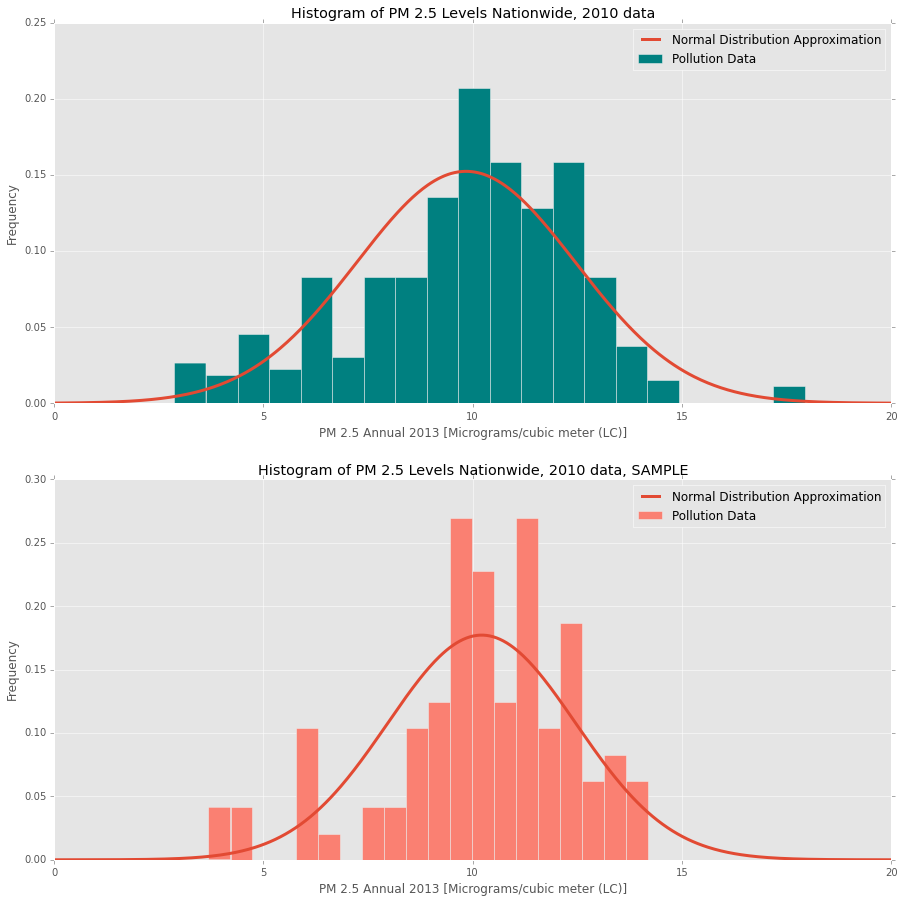

In [44]:
# Pollution data, Histogram
pl.figure(figsize=(15,15))
m, sd = stats.norm.fit(finale['pollution_mean'])
x = np.linspace(0,40,1000)
y = stats.norm.pdf(x, m, sd)

pl.subplot(211)
bins, hist, patches = pl.hist(finale['pollution_mean'], bins=20, normed=True, label='Pollution Data', color='teal')
pl.plot(x,y, linewidth=3, label='Normal Distribution Approximation')
pl.xlabel('PM 2.5 Annual 2013 [Micrograms/cubic meter (LC)]')
pl.ylabel('Frequency')
pl.title('Histogram of PM 2.5 Levels Nationwide, 2010 data')
pl.xlim(0,20)
pl.legend()

pl.subplot(212)
m, sd = stats.norm.fit(sample['pollution_mean'].values)
x = np.linspace(0,40,1000)
y = stats.norm.pdf(x, m, sd)

bins, hist, patches = pl.hist(sample['pollution_mean'].values, bins=20, normed=True, label='Pollution Data', color='salmon')
pl.plot(x,y, linewidth=3, label='Normal Distribution Approximation')
pl.xlabel('PM 2.5 Annual 2013 [Micrograms/cubic meter (LC)]')
pl.ylabel('Frequency')
pl.title('Histogram of PM 2.5 Levels Nationwide, 2010 data, SAMPLE')
pl.xlim(0,20)
pl.legend()

plt.savefig("Histo_pollution.png")

In [45]:
print sd

2.25163029215


***For Kolmogorov-Smirnov test for goodness of fit:***

H0: The two variables/samples are drawn from the same distribution

H1: The two variables/samples are not drawn from the same distribution

In [46]:
ks = scipy.stats.kstest(ofinterest_sample['pollution_mean'], 'norm', args=(m,sd))
print 't score:',ks[0],'p-value:',ks[1]

t score: 0.112401121469 p-value: 0.181307006788


The p-value is larger than $\alpha$ of 5%. Hence, one fails to reject $H_0$

C:\Users\Dan\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


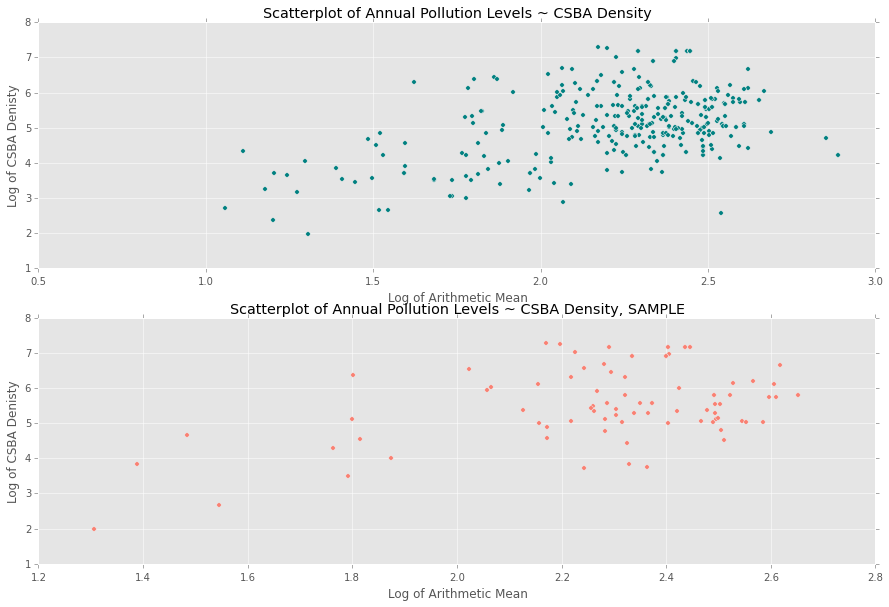

In [47]:
# Polution data and county population density, Scatterplot
pl.figure(figsize=(15,15))
pl.subplot(311)
pl.scatter(np.log(finale['pollution_mean']), np.log(finale['cbsa_density']), c='teal')
pl.xlabel('Log of Arithmetic Mean')
pl.ylabel('Log of CSBA Denisty')
pl.title('Scatterplot of Annual Pollution Levels ~ CSBA Density')
pl.subplot(312)
pl.scatter(np.log(sample['pollution_mean']), np.log(sample['cbsa_density']), c='salmon')
pl.xlabel('Log of Arithmetic Mean')
pl.ylabel('Log of CSBA Denisty')
pl.title('Scatterplot of Annual Pollution Levels ~ CSBA Density, SAMPLE')

plt.savefig("Scatter_poll_dens.png")

Descriptives for population: count        352.000000
mean      825205.230114
std      1426635.962035
min        60888.000000
25%       147033.500000
50%       287702.000000
75%       670168.250000
max      6371773.000000
Name: population, dtype: float64
-------------------------------------
Descriptives for population, SAMPLE: count         92.000000
mean     1957066.195652
std      2074625.424857
min       109299.000000
25%       415829.750000
50%       901953.000000
75%      2812896.000000
max      6371773.000000
Name: population, dtype: float64


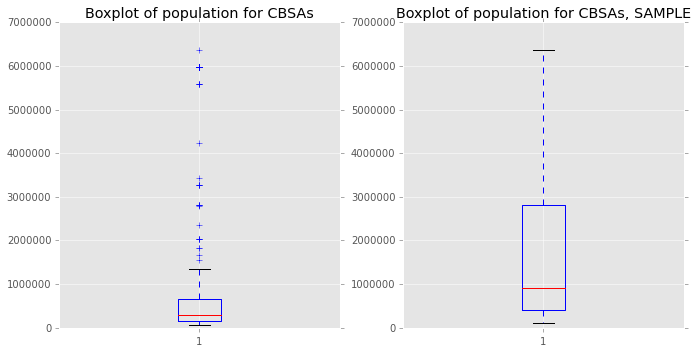

In [48]:
pl.figure(figsize=(10,5))
pl.subplot(121)
pl.boxplot(finale.population)
pl.title('Boxplot of population for CBSAs')
pl.subplot(122)
pl.boxplot(sample.population.values)
pl.title('Boxplot of population for CBSAs, SAMPLE')
pl.tight_layout()
print 'Descriptives for population:',finale.population.describe()
print '-------------------------------------'
print 'Descriptives for population, SAMPLE:',sample.population.describe()

Descriptives for population: count     352.000000
mean      281.993807
std       304.730929
min         7.220000
25%       105.945000
50%       169.505000
75%       326.200000
max      1467.190000
Name: cbsa_density, dtype: float64
-------------------------------------
Descriptives for population, SAMPLE: count      92.000000
mean      470.585652
std       439.582153
min         7.220000
25%       155.867500
50%       260.030000
75%       692.720000
max      1467.190000
Name: cbsa_density, dtype: float64


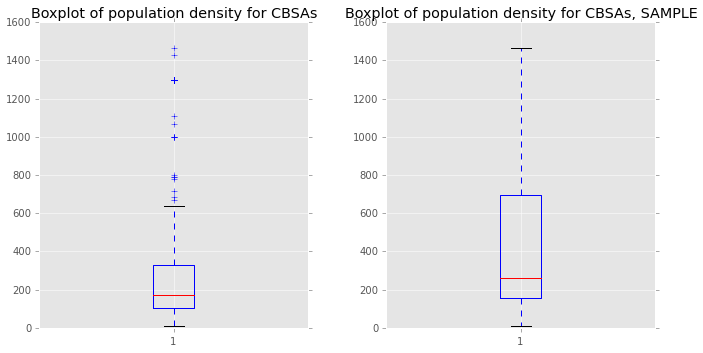

In [49]:
pl.figure(figsize=(10,5))
pl.subplot(121)
pl.boxplot(finale.cbsa_density)
pl.title('Boxplot of population density for CBSAs')
pl.subplot(122)
pl.boxplot(sample.cbsa_density.values)
pl.title('Boxplot of population density for CBSAs, SAMPLE')
pl.tight_layout()
print 'Descriptives for population:',finale.cbsa_density.describe()
print '-------------------------------------'
print 'Descriptives for population, SAMPLE:',sample.cbsa_density.describe()

### Let's look at the distribution of daily pollution levels for selected states

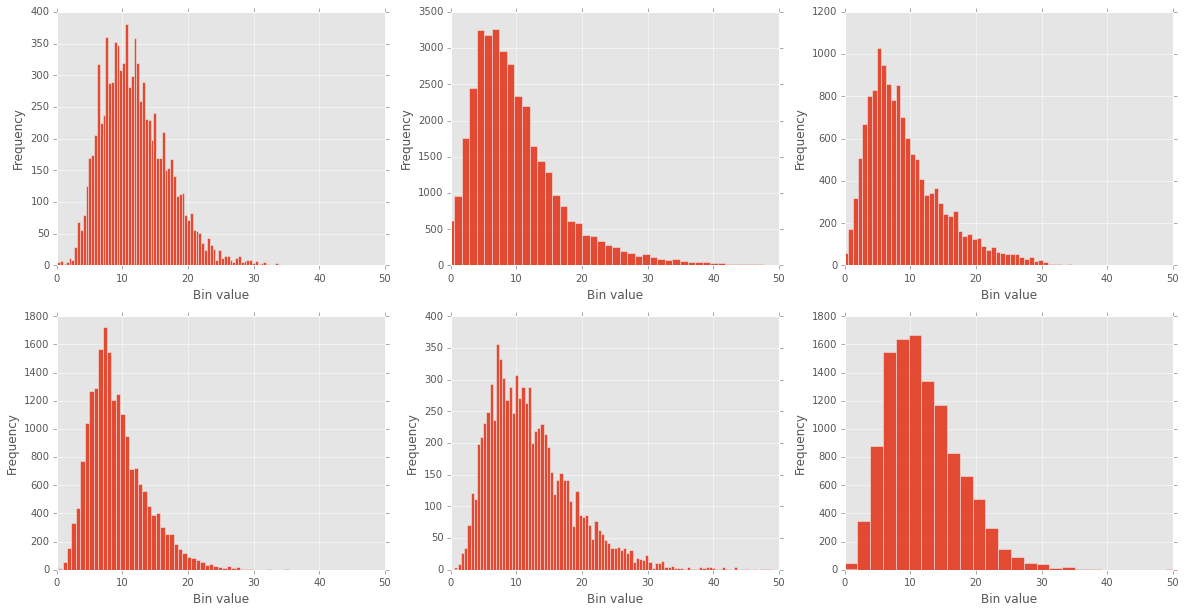

In [50]:
al = df[df['STATE']=='Alabama']['Daily Mean PM2.5 Concentration']
cal = df[df['STATE']=='California']['Daily Mean PM2.5 Concentration']
ny = df[df['STATE']=='New York']['Daily Mean PM2.5 Concentration']
tex = df[df['STATE']=='Texas']['Daily Mean PM2.5 Concentration']
ill = df[df['STATE']=='Illinois']['Daily Mean PM2.5 Concentration']
geo = df[df['STATE']=='Georgia']['Daily Mean PM2.5 Concentration']
lis = (al,cal,ny,tex,ill,geo)
pl.figure(figsize=(20,10))
for m,z in zip(lis, range(len(lis))):
    z = z + 1
    pl.subplot(2,3,z)
    pl.hist(m, bins=100);
    pl.xlim(0,50)
    pl.xlabel('Bin value')
    pl.ylabel('Frequency')

C:\Users\Dan\Anaconda\lib\site-packages\matplotlib\axes\_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


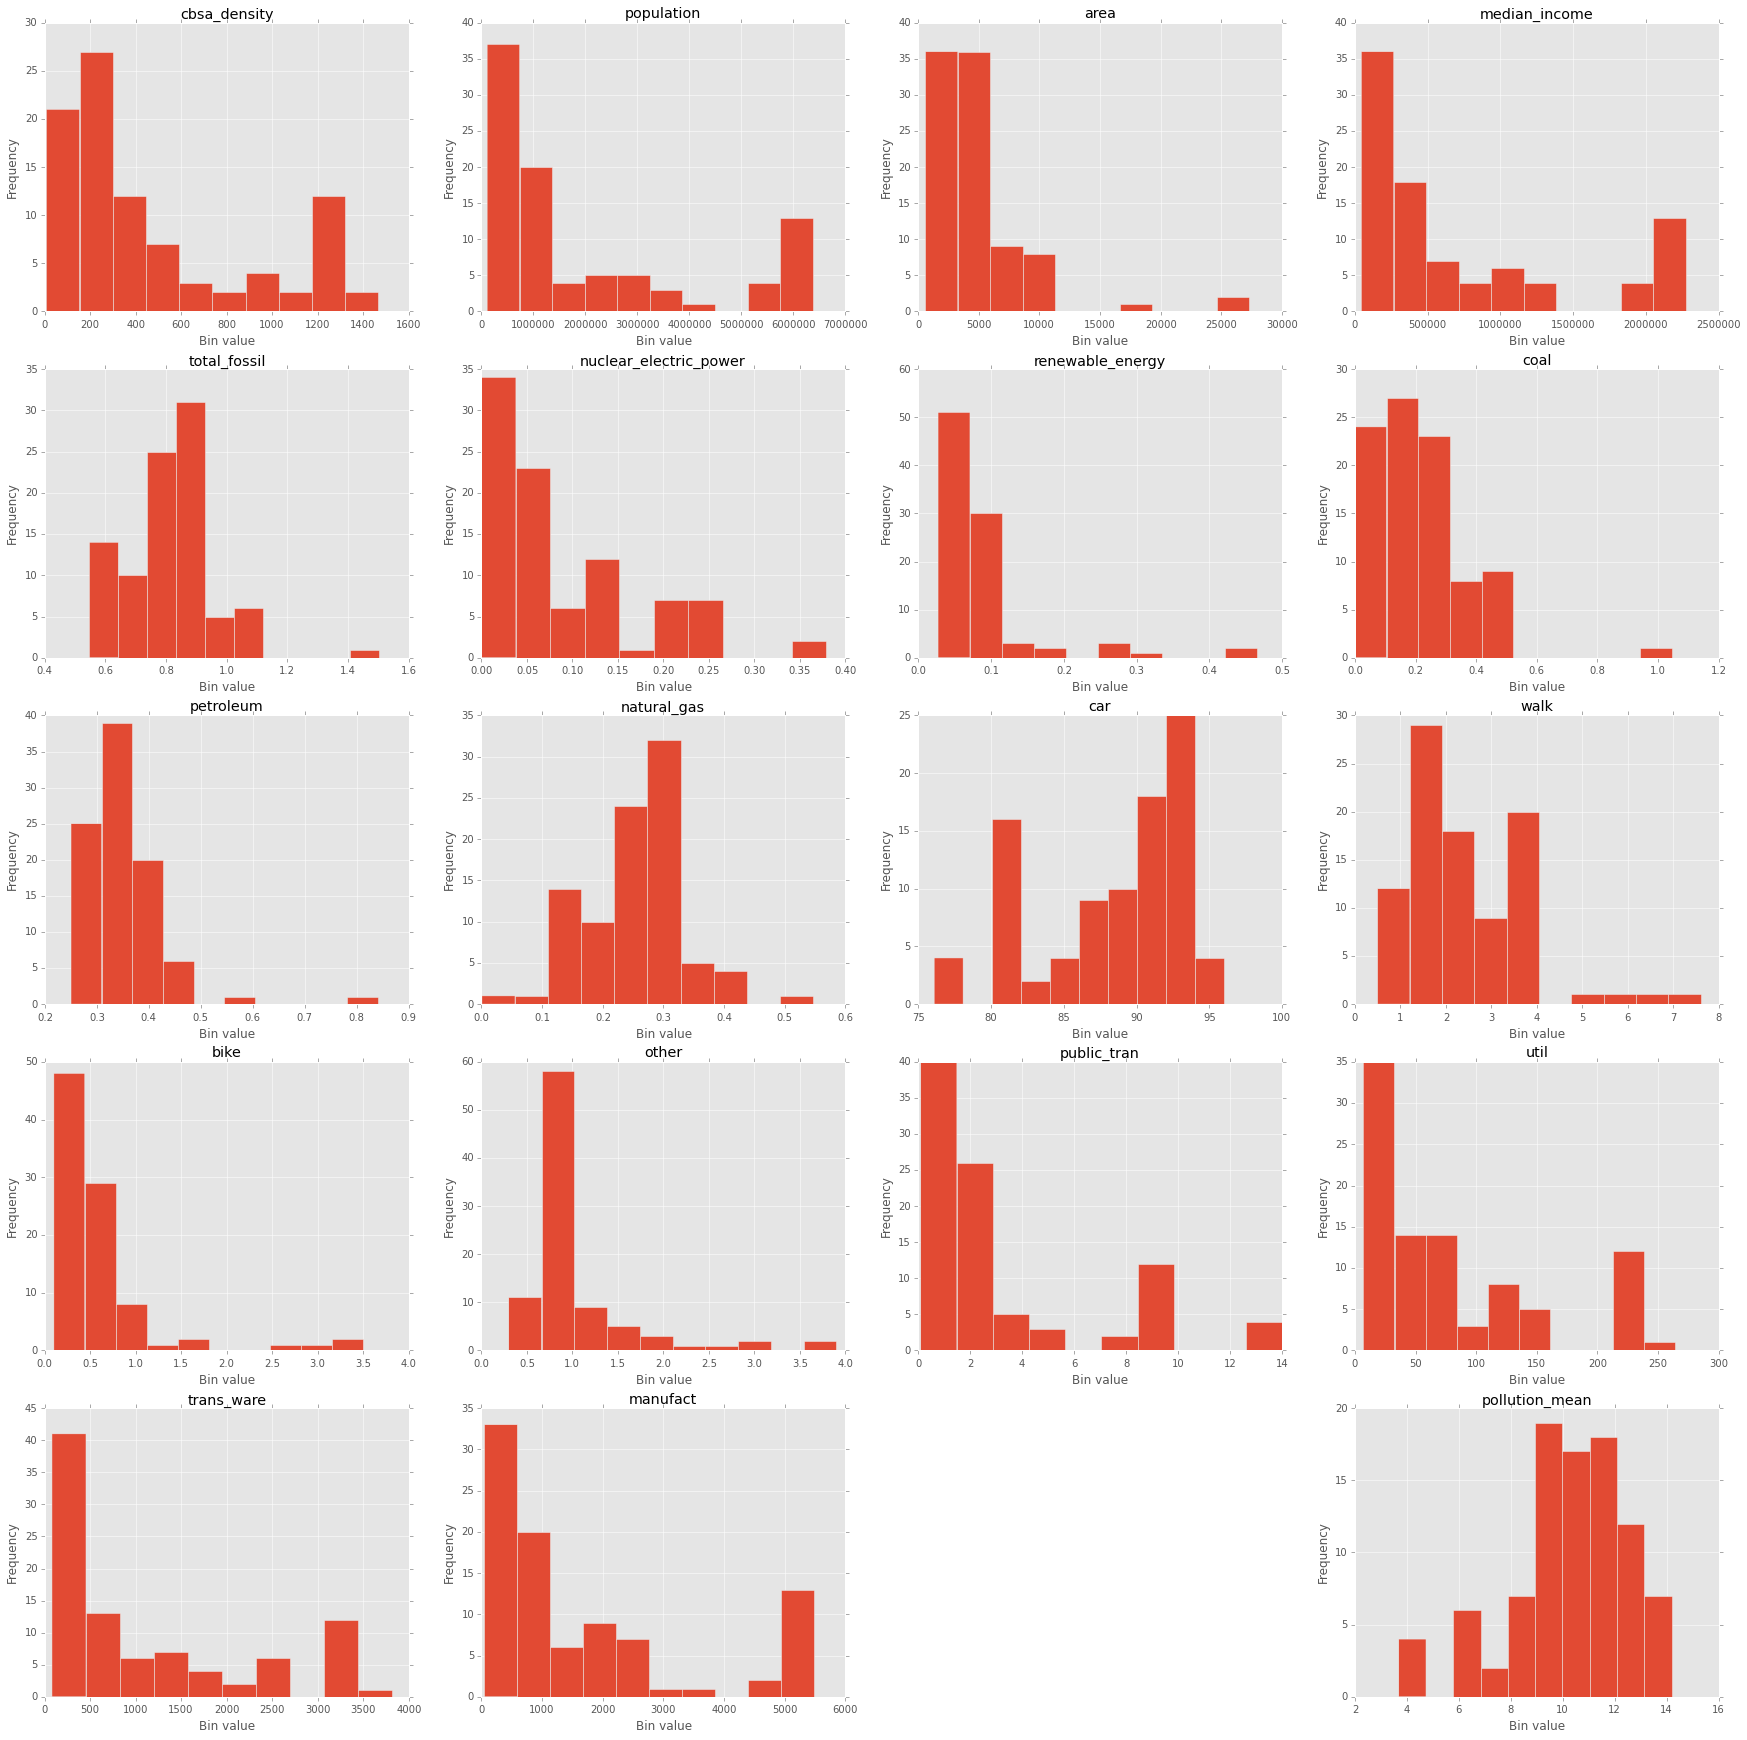

In [51]:
pl.figure(figsize=(30,30))
for i,z in zip(ofinterest_sample.columns,range(len(ofinterest_sample.columns))):
    pl.subplot(5,4,z)
    bins, hist, patches = pl.hist(ofinterest_sample[i].values);
    m, sd = stats.norm.fit(ofinterest_sample[i].values)
    x = np.linspace(bins.min(),bins.max(),100)
    y = stats.norm.pdf(x, m, sd)
    #pl.plot(x,y, linewidth=3, label='Normal Distribution Approximation')
    z = z + 1
    pl.title(i)
    pl.xlabel('Bin value')
    pl.ylabel('Frequency')

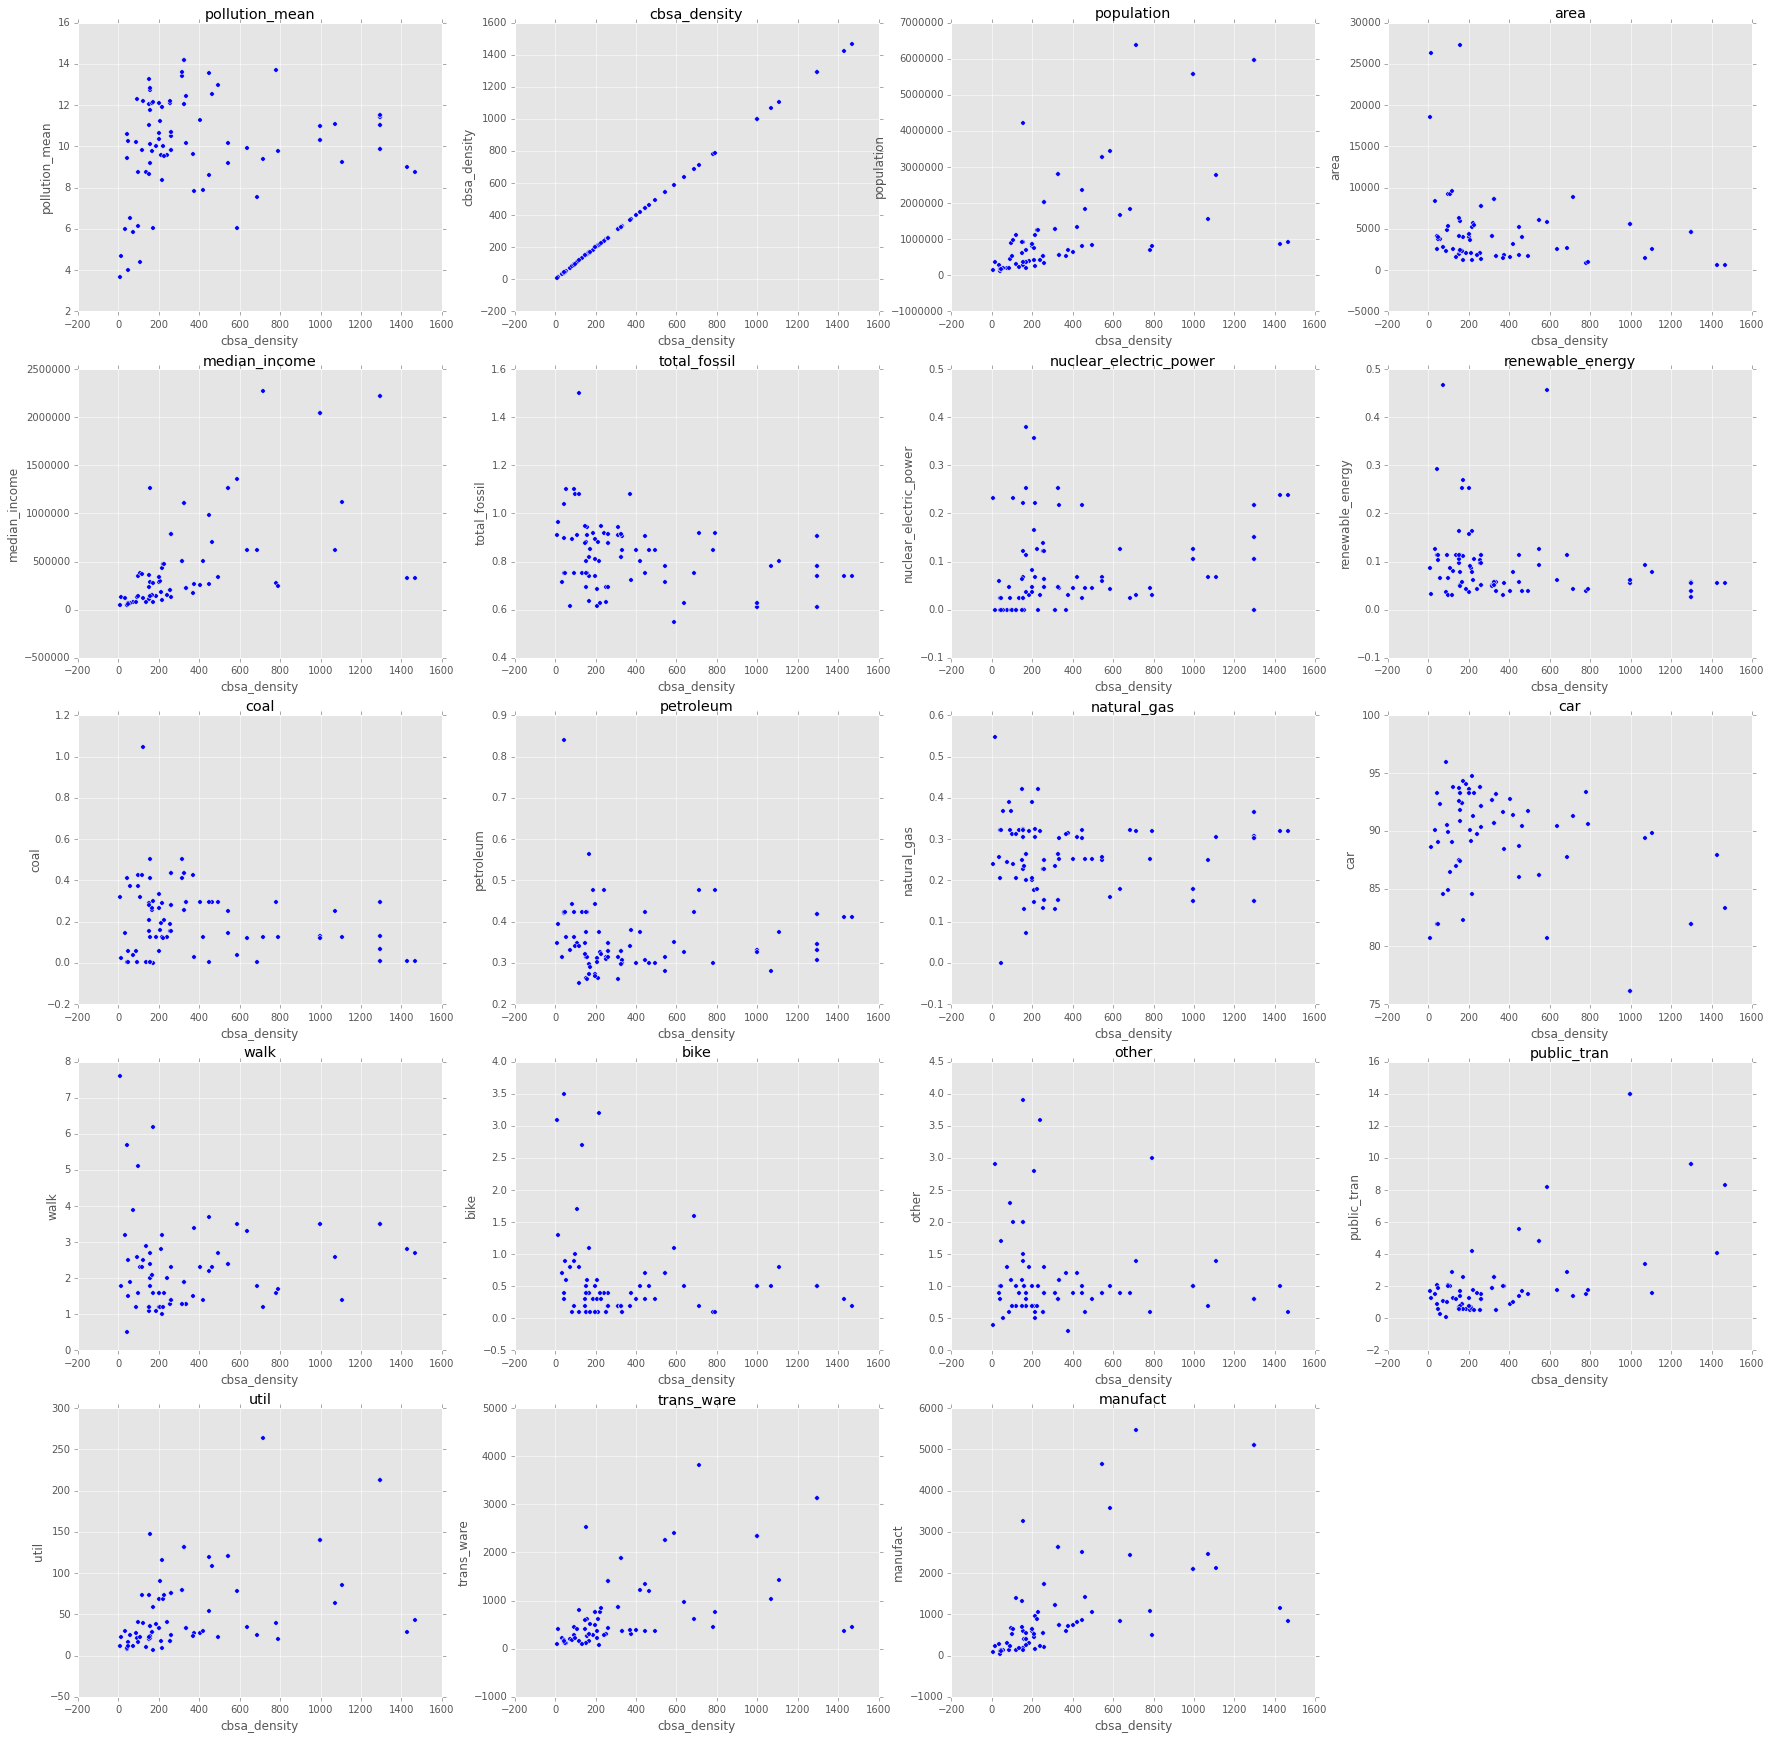

In [52]:
# Sample
pl.figure(figsize=(30,30))
for i,z in zip(ofinterest_sample.columns,range(len(ofinterest_sample.columns))):
    z = z + 1
    pl.subplot(5,4,z)
    pl.scatter(ofinterest_sample['cbsa_density'],ofinterest_sample[i].values)
    pl.title(i)
    pl.xlabel('cbsa_density')
    pl.ylabel(i)

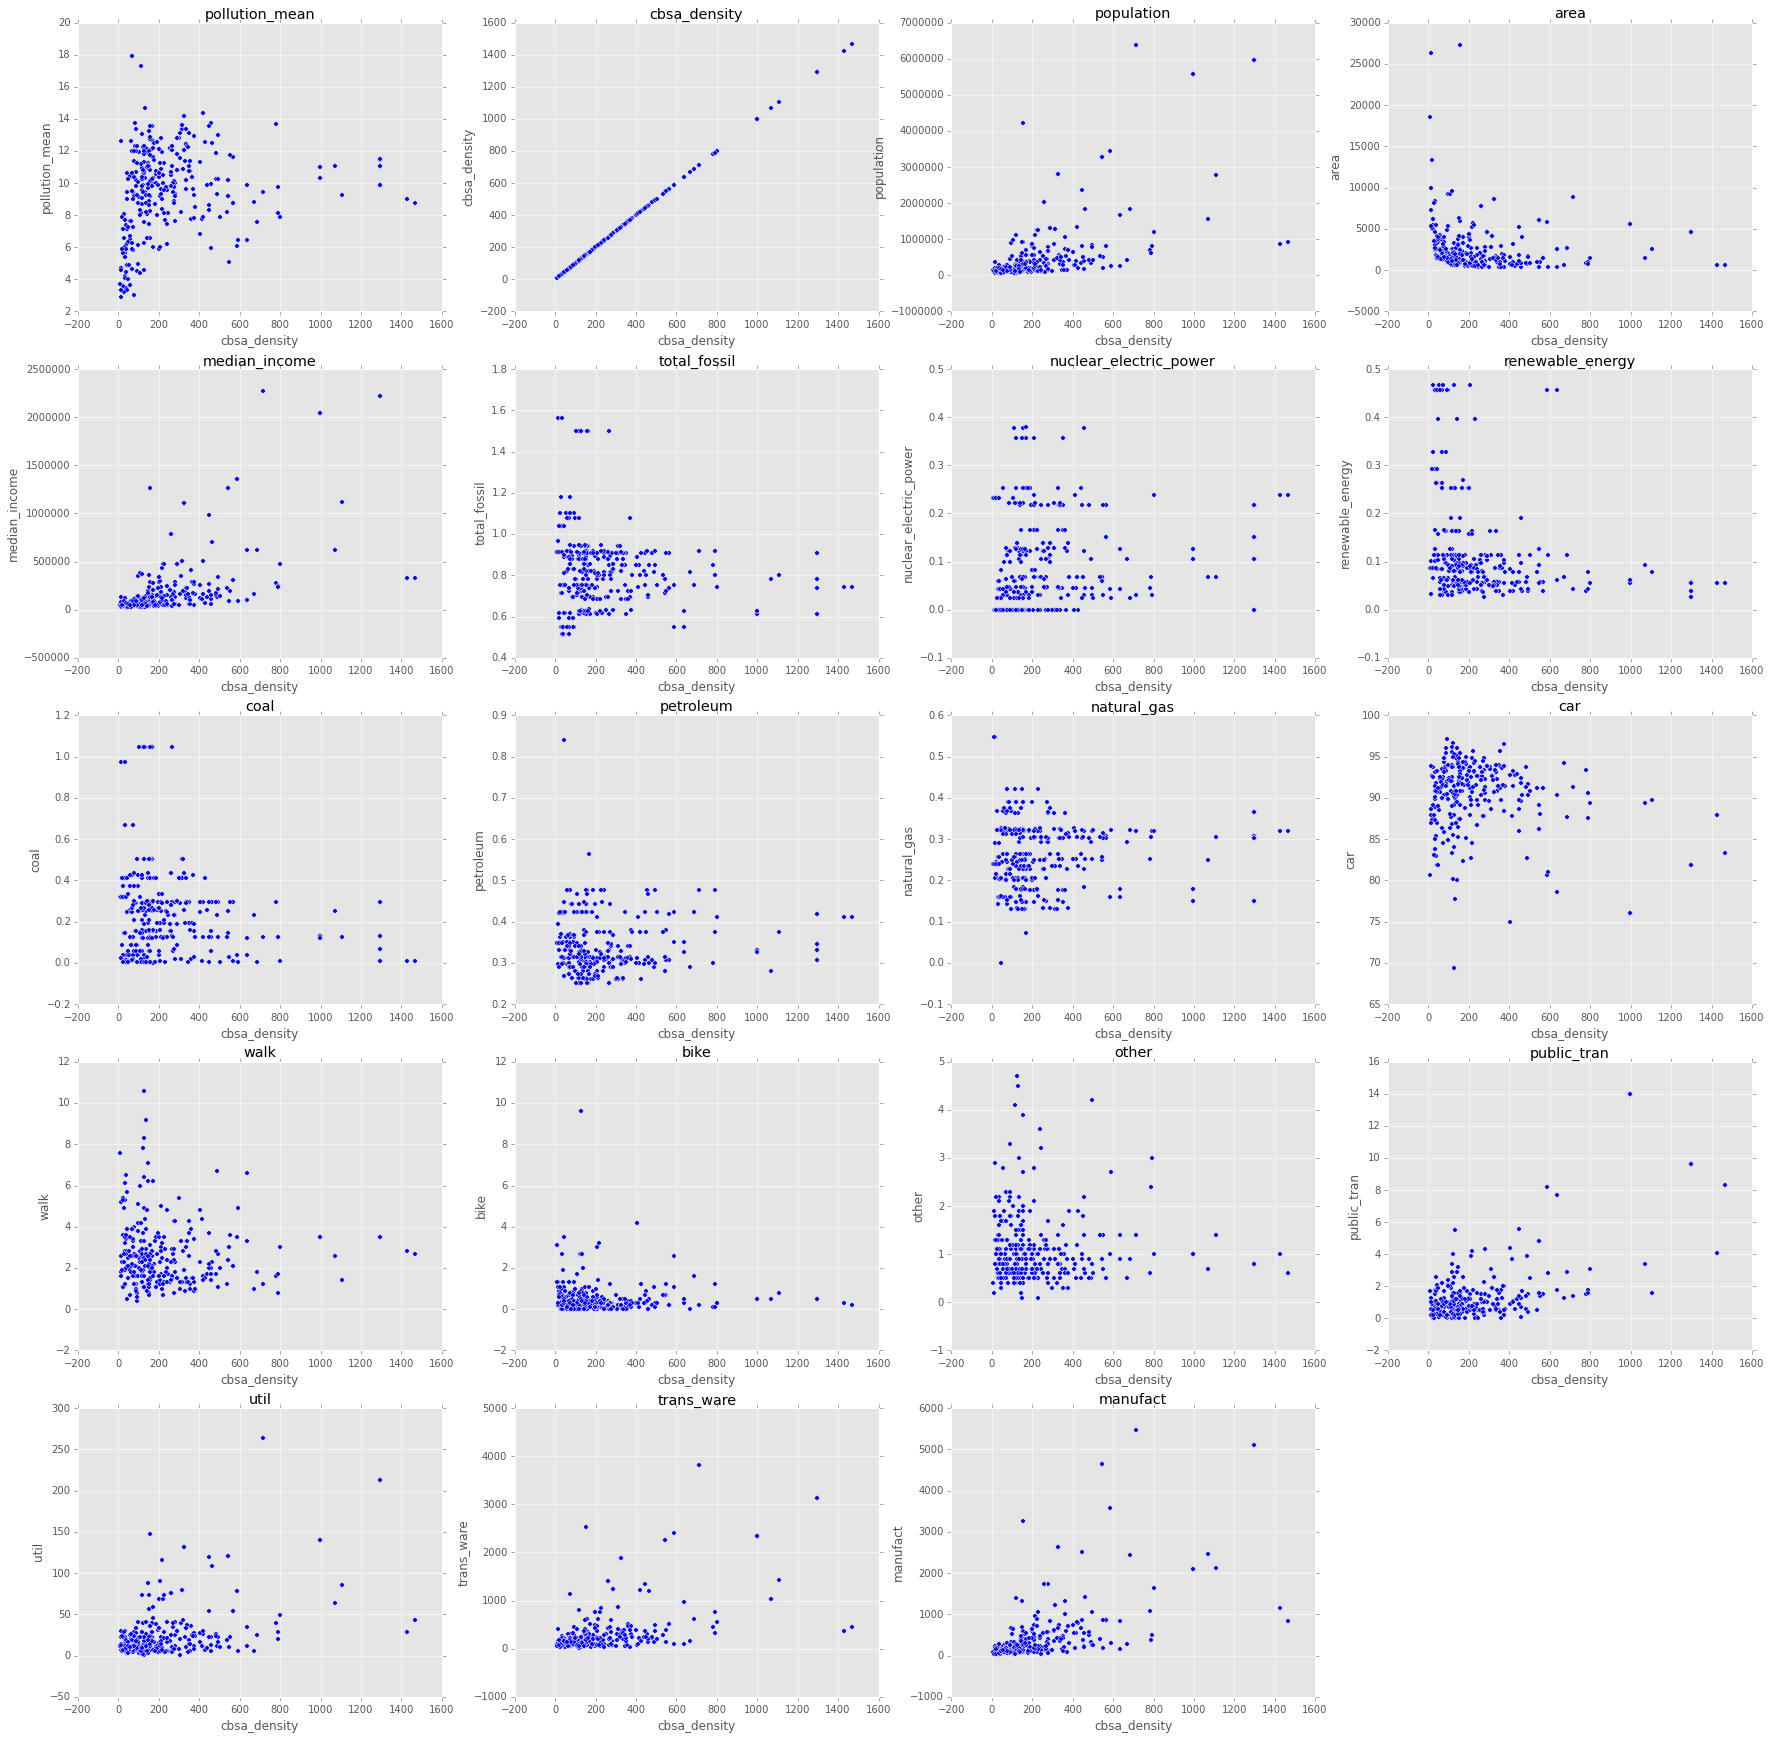

In [53]:
# Whole dataset
pl.figure(figsize=(30,30))
for i,z in zip(ofinterest.columns,range(len(ofinterest.columns))):
    z = z + 1
    pl.subplot(5,4,z)
    pl.scatter(ofinterest['cbsa_density'],ofinterest[i].values)
    pl.title(i)
    pl.xlabel('cbsa_density')
    pl.ylabel(i)

95.7391304348


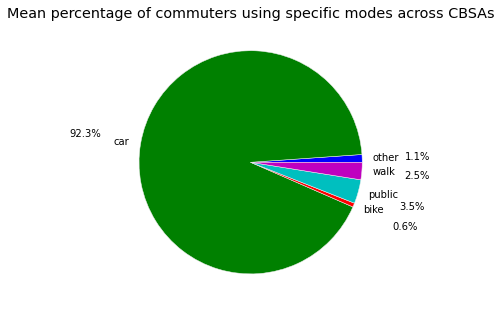

In [54]:
pl.figure(figsize=(5,5))
mean = {}
mean['bike'] = sample['bike'].mean()
mean['public'] = sample['public_tran'].mean()
mean['car'] = sample['car'].mean()
mean['other'] = sample['other'].mean()
mean['walk'] = sample['walk'].mean()

print np.sum(mean.values())
plt.pie(mean.values(), labels=mean.keys(), autopct='%1.1f%%',
        shadow=False, pctdistance=1.5, labeldistance=1.1);
pl.title('Mean percentage of commuters using specific modes across CBSAs')

plt.savefig("Pie.png")

0.996730065707


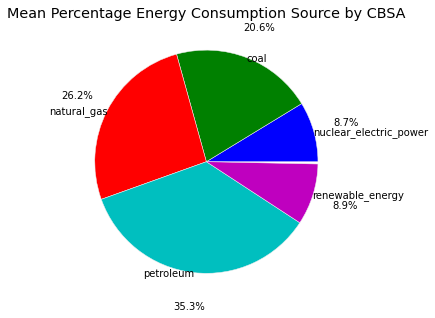

In [55]:
pl.figure(figsize=(5,5))
mean = {}
mean['coal'] = sample['coal'].mean()
mean['natural_gas'] = sample['natural_gas'].mean()
mean['petroleum'] = sample['petroleum'].mean()
mean['nuclear_electric_power'] = sample['nuclear_electric_power'].mean()
mean['renewable_energy'] = sample['renewable_energy'].mean()

print np.sum(mean.values())
plt.pie(mean.values(), labels=mean.keys(), autopct='%1.1f%%',
        shadow=False, pctdistance=1.3, labeldistance=1);
pl.title('Mean Percentage Energy Consumption Source by CBSA')

plt.savefig("Pie.png")

In [56]:
final.head()

,pollution_mean,state,num_of_station,CBSAName_low,CBSA_Code,CBSAName,Population,Area,cbsa_density,index,...,walk,bike,other,total_energy,coal,natural_gas,petroleum,total_fossil,nuclear_electric_power,renewable_energy
0,3.464279,Washington,3,"aberdeen, wa",10140,"Aberdeen, WA",72797,1902.03,38.27,310M100US10140,...,3.4,0.3,0.9,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559
1,4.928976,Washington,2,"bellingham, wa",13380,"Bellingham, WA",201140,2106.86,95.47,310M100US13380,...,4.2,1.3,1.8,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559
2,6.434375,Washington,1,"bremerton-silverdale, wa",14740,"Bremerton-Silverdale, WA",251133,394.94,635.87,310M100US14740,...,6.6,0.3,1.4,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559
3,4.237317,Washington,2,"centralia, wa",16500,"Centralia, WA",75455,2402.80,31.40,310M100US16500,...,2.8,0.0,1.3,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559
4,7.163788,Washington,1,"lewiston, id-wa",30300,"Lewiston, ID-WA",60888,1484.30,41.02,310M100US30300,...,3.9,0.0,1.8,2039.3,0.036777,0.16084,0.349728,0.547296,0.043348,0.457559


# Regression Model

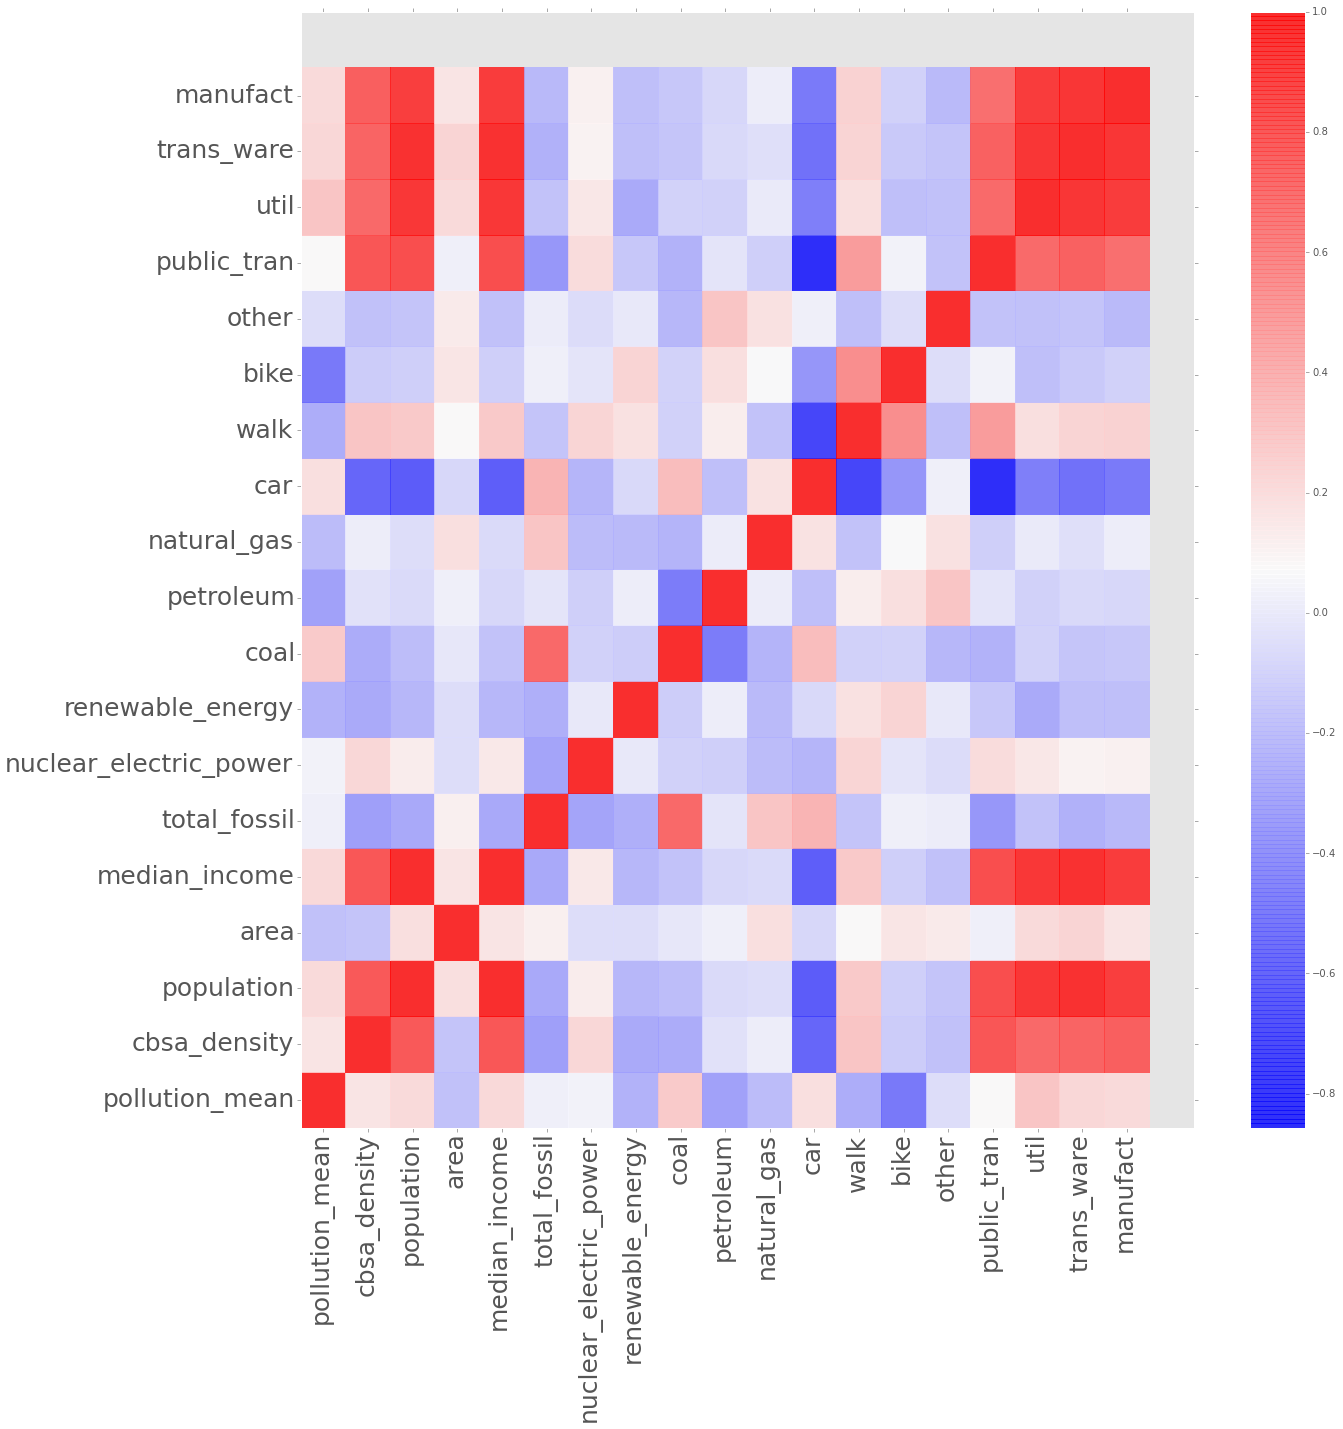

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
R = ofinterest_sample.corr()
pl.pcolor(R, label=ofinterest_sample.columns, alpha=0.8, cmap='bwr') # or seismic
pl.colorbar()
yticks(arange(0.5,19.5),range(0,20))
xticks(arange(0.5,19.5),range(0,20))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i,v in zip(ofinterest.columns,range(len(ofinterest.columns))):
    labels[v] = i
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
pl.tick_params(axis='both', which='major', labelsize=25)

In [58]:
ofinterest_sample.corr()

,pollution_mean,cbsa_density,population,area,median_income,total_fossil,nuclear_electric_power,renewable_energy,coal,petroleum,natural_gas,car,walk,bike,other,public_tran,util,trans_ware,manufact
pollution_mean,1.000000,0.168673,0.212080,-0.187356,0.216849,0.023515,0.041305,-0.252637,0.283917,-0.334008,-0.207013,0.192713,-0.275378,-0.510589,-0.058849,0.074818,0.306429,0.229871,0.211155
cbsa_density,0.168673,1.000000,0.801434,-0.169297,0.806137,-0.336047,0.224894,-0.285920,-0.282399,-0.038520,0.014173,-0.599510,0.307672,-0.136963,-0.184460,0.812234,0.729956,0.752760,0.769591
population,0.212080,0.801434,1.000000,0.191951,0.998302,-0.297698,0.136189,-0.231895,-0.197855,-0.069009,-0.057713,-0.641285,0.295115,-0.117907,-0.172437,0.850636,0.950126,0.979176,0.927025
area,-0.187356,-0.169297,0.191951,1.000000,0.170934,0.115883,-0.057984,-0.057913,-0.008885,0.024015,0.193457,-0.081060,0.074703,0.165330,0.140663,0.021978,0.210341,0.241328,0.170572
median_income,0.216849,0.806137,0.998302,0.170934,1.000000,-0.296691,0.147325,-0.229012,-0.182428,-0.087287,-0.069307,-0.638538,0.294712,-0.121842,-0.187514,0.851882,0.951895,0.979859,0.931531
total_fossil,0.023515,-0.336047,-0.297698,0.115883,-0.296691,1.000000,-0.313380,-0.263412,0.729303,-0.026504,0.306923,0.388025,-0.170433,0.021890,0.009519,-0.371378,-0.177704,-0.259054,-0.222273
nuclear_electric_power,0.041305,0.224894,0.136189,-0.057984,0.147325,-0.313380,1.000000,-0.006428,-0.112699,-0.120105,-0.204481,-0.235612,0.233266,-0.027885,-0.059127,0.203472,0.155797,0.105986,0.109217
renewable_energy,-0.252637,-0.285920,-0.231895,-0.057913,-0.229012,-0.263412,-0.006428,1.000000,-0.126354,0.015887,-0.218017,-0.077012,0.184545,0.245218,-0.001810,-0.154799,-0.287547,-0.195713,-0.190431
coal,0.283917,-0.282399,-0.197855,-0.008885,-0.182428,0.729303,-0.112699,-0.126354,1.000000,-0.501039,-0.247727,0.339953,-0.115755,-0.105830,-0.229847,-0.248366,-0.104671,-0.162405,-0.160201
petroleum,-0.334008,-0.038520,-0.069009,0.024015,-0.087287,-0.026504,-0.120105,0.015887,-0.501039,1.000000,0.011367,-0.195475,0.123004,0.191429,0.307837,-0.028506,-0.111137,-0.079759,-0.086864


### Regression model: Sample without area and population

In [59]:
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + 
                             np.log(petroleum+np.exp(-100))
                             + np.log(nuclear_electric_power+np.exp(-100)) + np.log(renewable_energy+np.exp(-100)) 
                             + np.log(natural_gas+np.exp(-100)) +
                             np.log(car+np.exp(-100)) + np.log(walk+np.exp(-100)) + np.log(bike+np.exp(-100))
                             + np.log(public_tran + np.exp(-100))
                             + np.log(other+np.exp(-100)) + np.log(median_income) 
                             + np.log(util+np.exp(-100))
                             + np.log(trans_ware+np.exp(-100)) + np.log(manufact+np.exp(-100))''', 
                             data=ofinterest_sample).fit()
print model.summary()


                              OLS Regression Results                              
Dep. Variable:     np.log(pollution_mean)   R-squared:                       0.593
Model:                                OLS   Adj. R-squared:                  0.513
Method:                     Least Squares   F-statistic:                     7.378
Date:                    Sun, 13 Dec 2015   Prob (F-statistic):           1.01e-09
Time:                            12:51:23   Log-Likelihood:                 32.178
No. Observations:                      92   AIC:                            -32.36
Df Residuals:                          76   BIC:                             7.993
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------

#### With robust SEs

### Regression with only significant explanatory variables, Sample

In [60]:
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + np.log(petroleum+np.exp(-100))
                             + np.log(nuclear_electric_power+np.exp(-100)) + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(public_tran+np.exp(-100)) + np.log(walk+np.exp(-100)) + np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             + np.log(manufact+np.exp(-100))''', 
                             data=ofinterest_sample).fit()
#exclude manufact
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + np.log(petroleum+np.exp(-100))
                             + np.log(nuclear_electric_power+np.exp(-100)) + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(public_tran+np.exp(-100)) + np.log(walk+np.exp(-100)) + np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             ''', 
                             data=ofinterest_sample).fit()
#exclude walk
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + np.log(petroleum+np.exp(-100))
                             + np.log(nuclear_electric_power+np.exp(-100)) + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(public_tran+np.exp(-100))  + np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             ''', 
                             data=ofinterest_sample).fit()
#exclude walk
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + np.log(petroleum+np.exp(-100))
                             + np.log(nuclear_electric_power+np.exp(-100)) + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             ''', 
                             data=ofinterest_sample).fit()
#exclude nuclear power
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(coal+np.exp(-100)) + np.log(petroleum+np.exp(-100))
                             + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             ''', 
                             data=ofinterest_sample).fit()
#exclude coal
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(petroleum+np.exp(-100))
                             + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(bike+np.exp(-100)) 
                             + np.log(other+np.exp(-100))
                             ''', 
                             data=ofinterest_sample).fit()
#exclude other
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(petroleum+np.exp(-100))
                             + np.log(renewable_energy+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(bike+np.exp(-100)) 
                             
                             ''', 
                             data=ofinterest_sample).fit()
#exclude renewable energy
model = smf.ols(formula = '''np.log(pollution_mean) ~ np.log(cbsa_density) + np.log(petroleum+np.exp(-100)) + 
                             np.log(natural_gas+np.exp(-100)) +
                             np.log(bike+np.exp(-100)) 
                             ''', 
                             data=ofinterest_sample).fit()
print 'Finale model: Manual backwards'
print model.summary()
fig = plt.figure(figsize=(20,10))
fig = plot_regress_exog(model, 'np.log(density)', fig=fig) 

Finale model: Manual backwards
                              OLS Regression Results                              
Dep. Variable:     np.log(pollution_mean)   R-squared:                       0.538
Model:                                OLS   Adj. R-squared:                  0.517
Method:                     Least Squares   F-statistic:                     25.31
Date:                    Sun, 13 Dec 2015   Prob (F-statistic):           6.39e-14
Time:                            12:51:28   Log-Likelihood:                 26.346
No. Observations:                      92   AIC:                            -42.69
Df Residuals:                          87   BIC:                            -30.08
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------

ValueError: 'np.log(density)' is not in list